In [1]:
import sys
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, make_scorer, matthews_corrcoef

import os
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from collections import Counter
label = LabelEncoder()
print(os.listdir("../input"))

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


['fraud-ug', 'fraud-test']


In [2]:
np.set_printoptions(threshold=sys.maxsize)

In [3]:
train = pd.read_csv("../input/fraud-ug/training.csv")
train["train"] = 1
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,train
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0,1
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0,1
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0,1
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0,1
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0,1


In [4]:
train.shape

(95662, 17)

In [5]:
fraud_data = train[train["FraudResult"] == 1.0]

In [6]:
train.shape

(95662, 17)

In [7]:
test = pd.read_csv("../input/fraud-test/test.csv")
test["train"] = 0
test.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,train
0,TransactionId_50600,BatchId_35028,AccountId_2441,SubscriptionId_4426,CustomerId_2857,UGX,256,ProviderId_5,ProductId_3,airtime,ChannelId_3,1000.0,1000,2019-02-13T10:01:40Z,4,0
1,TransactionId_95109,BatchId_45139,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_5,ProductId_15,financial_services,ChannelId_3,2000.0,2000,2019-02-13T10:02:12Z,2,0
2,TransactionId_47357,BatchId_74887,AccountId_4841,SubscriptionId_3829,CustomerId_2857,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-50.0,50,2019-02-13T10:02:30Z,2,0
3,TransactionId_28185,BatchId_11025,AccountId_2685,SubscriptionId_4626,CustomerId_3105,UGX,256,ProviderId_5,ProductId_10,airtime,ChannelId_3,3000.0,3000,2019-02-13T10:02:38Z,4,0
4,TransactionId_22140,BatchId_29804,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-60.0,60,2019-02-13T10:02:58Z,2,0


In [8]:
dataset = pd.concat([train, test], ignore_index=True)

In [9]:
dataset.shape

(140681, 17)

In [10]:
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,train
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0,1
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0,1
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0,1
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0,1
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0,1


In [11]:
# time
dataset["TransactionStartTime"] = dataset["TransactionStartTime"].apply(lambda x : pd.to_datetime(x))
# dataset["Month"] = dataset["TransactionStartTime"].dt.month
# dataset["day_of_month"] = dataset["TransactionStartTime"].dt.day
dataset["day_of_week"] = dataset["TransactionStartTime"].dt.dayofweek
# dataset["day_of_year"] = dataset["TransactionStartTime"].dt.dayofyear
dataset["time"] = dataset["TransactionStartTime"].dt.time
dataset["minute"] = dataset["time"].apply(lambda x: int(str(x).split(":")[0]) * 60 + int(str(x).split(":")[1]))

In [12]:
dataset.Amount.mean()

6050.577577640193

In [13]:
dataset.SubscriptionId = pd.DataFrame(label.fit_transform(dataset.SubscriptionId))
dataset.BatchId = pd.DataFrame(label.fit_transform(dataset.BatchId))
dataset.CustomerId = pd.DataFrame(label.fit_transform(dataset.CustomerId))
dataset.AccountId = pd.DataFrame(label.fit_transform(dataset.AccountId))


In [14]:
dataset = pd.concat([dataset, pd.get_dummies(dataset["ChannelId"], prefix="Channel_Id_")], axis=1)
dataset = pd.concat([dataset, pd.get_dummies(dataset["PricingStrategy"], prefix="PricingStrategy_")], axis=1)
dataset = pd.concat([dataset, pd.get_dummies(dataset["ProductCategory"], prefix="ProductCategory_")], axis=1)
dataset = pd.concat([dataset, pd.get_dummies(dataset["ProductId"], prefix="ProductId_")], axis=1)
dataset = pd.concat([dataset, pd.get_dummies(dataset["ProviderId"], prefix="ProviderId_")], axis=1)


In [15]:
dataset["weekday"] = dataset["TransactionStartTime"].dt.weekday_name

In [16]:
dataset = pd.concat([dataset, pd.get_dummies(dataset["weekday"], prefix="weekday")], axis=1)

In [17]:
# id
# dataset.SubscriptionId = pd.DataFrame(label.fit_transform(dataset.SubscriptionId))
# # dataset.BatchId = pd.DataFrame(label.fit_transform(dataset.BatchId))
# dataset.CustomerId = pd.DataFrame(label.fit_transform(dataset.CustomerId))
# dataset.AccountId = pd.DataFrame(label.fit_transform(dataset.AccountId))

In [18]:
# dataset["AccountId"] = dataset["AccountId"].apply(lambda x: int(x.split("_")[1]))
# dataset["SubscriptionId"] = dataset["SubscriptionId"].apply(lambda x: int(x.split("_")[1]))
# dataset["CustomerId"] = dataset["CustomerId"].apply(lambda x: int(x.split("_")[1]))
# dataset["BatchId"] = dataset["BatchId"].apply(lambda x: int(x.split("_")[1]))

In [19]:
dataset.shape

(140681, 80)

In [20]:
dataset.shape

(140681, 80)

In [21]:
# group = dataset[["AccountId", 'Amount', 'Month']].groupby(by=["AccountId", 'Amount'])[['Month']].mean().reset_index().rename(index=str, columns={'Month': 'Cust_value_month'})
# dataset = dataset.merge(group, how='left')

In [22]:
# group = dataset[["AccountId", 'Amount', 'Month']].groupby(by=["AccountId", 'Amount'])[['Month']].count().reset_index().rename(index=str, columns={'Month': 'Cust_value_month_count'})
# dataset = dataset.merge(group, how='left')

In [23]:
# group = dataset[['AccountId','Amount', 'PricingStrategy', 'ProductId','ProviderId', 'CustomerId', 'day_of_week', 'ChannelId']].groupby(by=['CustomerId', 'ProductId', 'ProviderId', 'ChannelId', 'Amount'])[['day_of_week']].mean().reset_index().rename(index=str, columns={'day_of_week': 'Cust_prod_mean_dayofweek'})
# dataset = dataset.merge(group, on=['CustomerId', 'ProductId', 'ProviderId', 'ChannelId'], how='left')


In [24]:
# group = dataset[['CustomerId', 'ProductId', 'ProviderId', 'ChannelId', 'Amount', 'day_of_week']].groupby(by=['CustomerId', 'ProductId', 'ProviderId', 'ChannelId', 'Amount',])[['day_of_week']].count().reset_index().rename(index=str, columns={'day_of_week': 'Cust_prod_mean_dayofweek'})
# dataset = dataset.merge(group, on=['CustomerId', 'ProductId', 'ProviderId', 'ChannelId',], how='left')

In [25]:
dataset.drop(["CurrencyCode", "CountryCode", "BatchId", "time", "TransactionStartTime", "ChannelId", "PricingStrategy", "ProductCategory", "ProductId", "ProviderId", "weekday"], axis=1, inplace=True)

In [26]:
train = dataset[dataset["train"] == 1]
test = dataset[dataset["train"] == 0]

In [27]:
test.shape

(45019, 69)

In [28]:
train.drop(["train"], axis=1, inplace=True)
test.drop(["train", "FraudResult"], axis=1, inplace=True)

Text(0, 0.5, 'PC2')

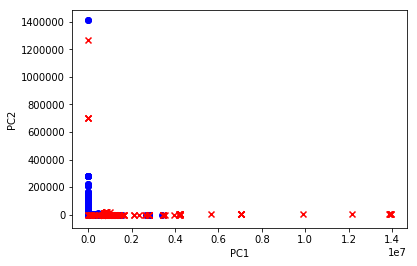

In [29]:
from sklearn.decomposition import PCA


reduced = PCA(n_components=2).fit_transform(train.drop(["TransactionId", "FraudResult"], axis=1).values)

plt.figure()
plt.scatter(reduced[train["FraudResult"] == 0, 0], reduced[train["FraudResult"] == 0, 1], color='blue')
plt.scatter(reduced[train["FraudResult"] == 1, 0], reduced[train["FraudResult"] == 1, 1], color='red', marker='x')
plt.xlabel("PC1")
plt.ylabel("PC2")

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
train.drop(["TransactionId"], axis=1, inplace=True)

In [32]:
X = train.drop(["FraudResult"], axis=1)
y = train["FraudResult"]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [34]:
print("Fraud case", (train["FraudResult"].value_counts()[1]/ len(train) * 100), "% of the dataset")
print ("Train size", y_train.shape[0], "Fraud in train size", y_train[y_train == 1].shape[0] / y_train.shape[0] * 100)
print ("Test size", y_test.shape[0], "Fraud in tesst size", y_test[y_test == 1].shape[0] / y_test.shape[0] * 100)

Fraud case 0.20175200183981098 % of the dataset
Train size 64093 Fraud in train size 0.19970979670166789
Test size 31569 Fraud in tesst size 0.2058981912635814


In [35]:
# # implement grid search
# rfc_param_grid = {
#     'n_estimators': [200, 250, 300, 400],
#     'max_depth': [5, 7, 8, 10],
#   
# }


In [36]:
# rfc_sk =  RandomForestClassifier(random_state=1)

In [37]:
# from sklearn.model_selection import GridSearchCV
# grid_mse = GridSearchCV(param_grid=rfc_param_grid, estimator=rfc_sk,
# scoring="f1", cv=4 )

In [38]:
# grid_mse.fit(X, y)

In [39]:
# grid_mse.best_params_

In [40]:
# grid_mse.best_score_

In [41]:
from sklearn.svm import SVC

In [42]:
svc = SVC(random_state=1)

##### logistc regression

In [43]:
gbc = GradientBoostingClassifier(n_estimators=200, max_depth=5)

In [44]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [45]:
gbc_pred = gbc.predict(X_test)

In [46]:
print(classification_report(y_test, gbc_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     31504
         1.0       0.83      0.88      0.85        65

    accuracy                           1.00     31569
   macro avg       0.91      0.94      0.93     31569
weighted avg       1.00      1.00      1.00     31569



In [47]:
# classifier
xg_cl = xgb.XGBClassifier(objective="binary:logistic",
                          n_estimators=200, colsample_bytree=0.7, subsample=0.7, max_depth=5, learning_rate=0.1, seed=1)


In [48]:
MCC_scorer = make_scorer(matthews_corrcoef)

In [49]:
# rfc = RandomForestClassifier(random_state=1, max_depth=8, n_estimators=200,)
pipeline_rf = Pipeline([
    ('model', RandomForestClassifier(max_depth=9, n_jobs=-1, random_state=1))
])
param_grid_rf = {'model__n_estimators': [50, 75, 100, 150, 200, 250, 300]
                 }

grid_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf,
                       scoring=MCC_scorer, n_jobs=-1, pre_dispatch='2*n_jobs',
                       cv=8, verbose=1, return_train_score=False)

grid_rf.fit(X_train, y_train)

Fitting 8 folds for each of 7 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:  3.5min finished


GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=9,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                       

In [50]:
grid_rf.fit(X_train, y_train)

Fitting 8 folds for each of 7 candidates, totalling 56 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:  3.5min finished


GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=9,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples_split=2,
                       

In [51]:
grid_rf_pred = grid_rf.predict(X_test)

In [52]:
print("rfc ", classification_report(y_test, grid_rf_pred) )

rfc                precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     31504
         1.0       0.89      0.88      0.88        65

    accuracy                           1.00     31569
   macro avg       0.95      0.94      0.94     31569
weighted avg       1.00      1.00      1.00     31569



In [53]:
xg_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1,
              silent=None, subsample=0.7, verbosity=1)

In [54]:
preds = xg_cl.predict(X_test)

In [55]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     31504
         1.0       0.85      0.89      0.87        65

    accuracy                           1.00     31569
   macro avg       0.93      0.95      0.94     31569
weighted avg       1.00      1.00      1.00     31569



In [56]:
test.head()

,AccountId,Amount,CustomerId,SubscriptionId,TransactionId,Value,day_of_week,minute,Channel_Id__ChannelId_1,Channel_Id__ChannelId_2,...,ProviderId__ProviderId_4,ProviderId__ProviderId_5,ProviderId__ProviderId_6,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
95662,1603,1000.0,2064,3808,TransactionId_50600,1000,2,601,0,0,...,0,1,0,0,0,0,0,0,0,1
95663,2711,2000.0,3194,1827,TransactionId_95109,2000,2,602,0,0,...,0,1,0,0,0,0,0,0,0,1
95664,4269,-50.0,2064,3144,TransactionId_47357,50,2,602,0,1,...,1,0,0,0,0,0,0,0,0,1
95665,1873,3000.0,2341,4030,TransactionId_28185,3000,2,602,0,0,...,0,1,0,0,0,0,0,0,0,1
95666,4269,-60.0,2341,3144,TransactionId_22140,60,2,602,0,1,...,1,0,0,0,0,0,0,0,0,1


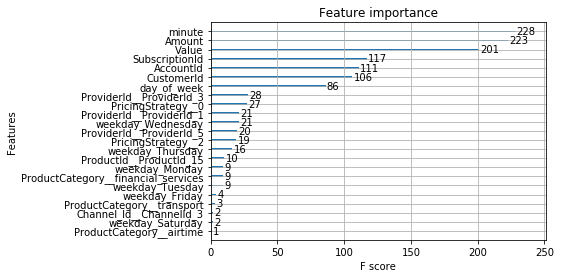

In [57]:
xgb.plot_importance(xg_cl)
plt.rcParams['figure.figsize'] = [15, 5]

In [58]:
# combine models
# gbc
# xgb
# rfc
models = [
    xgb.XGBClassifier(objective="binary:logistic",
                          n_estimators=200, colsample_bytree=0.7, subsample=0.7, max_depth=5, learning_rate=0.1, seed=1),
    RandomForestClassifier(random_state=1, max_depth=8, n_estimators=200,)
    
]

preds = pd.DataFrame()
for i, m in enumerate(models):
    print(m)
    m.fit(X_train, y_train),
    preds[i] = m.predict_proba(X_test)[:,1]

weights = [0.3, 1]
preds['weighted_pred'] = (preds * weights).sum(axis=1) / sum(weights)
preds.head()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1,
              silent=None, subsample=0.7, verbosity=1)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)


,0,1,weighted_pred
0,0.000004,0.000096,0.000075
1,0.000003,0.000121,0.000094
2,0.000009,0.000123,0.000097
3,0.000154,0.000052,0.000075
4,0.000009,0.000684,0.000528


In [59]:
total_pred = np.where(preds["weighted_pred"] > 0.5, 1, 0)

In [60]:
print(classification_report(y_test, total_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     31504
         1.0       0.88      0.89      0.89        65

    accuracy                           1.00     31569
   macro avg       0.94      0.95      0.94     31569
weighted avg       1.00      1.00      1.00     31569



In [61]:
test_pred = pd.DataFrame()
test_pred['TransactionId'] = test["TransactionId"]
test_sub = test.copy()
test_sub.drop(["TransactionId"], axis=1, inplace=True)

In [62]:
models = [
    xgb.XGBClassifier(objective="binary:logistic",
                          n_estimators=200, colsample_bytree=0.7, subsample=0.7, max_depth=5, learning_rate=0.1, seed=1),
    RandomForestClassifier(random_state=1, max_depth=8, n_estimators=200,)
    
]

preds = pd.DataFrame()
for i, m in enumerate(models):
    m.fit(X_train, y_train),
    preds[i] = m.predict_proba(test_sub)[:,1]

weights = [0.3, 1]
preds['weighted_pred'] = (preds * weights).sum(axis=1) / sum(weights)
preds.head()

,0,1,weighted_pred
0,0.000016,0.000112,0.000090
1,0.000031,0.000567,0.000443
2,0.000032,0.000035,0.000034
3,0.000015,0.000101,0.000081
4,0.000032,0.000035,0.000034


In [63]:
# predict_test = np.where(preds["weighted_pred"] > 0.5, 1, 0)
predict_test = grid_rf.predict(test_sub)
test_pred['FraudResult'] = predict_test
test_pred.to_csv('submission.csv', index=False)

In [64]:
import lightgbm as lgbm

In [65]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

In [66]:
# making lgbm datasets for train and valid
d_train = lgbm.Dataset(X_train, Y_train)
d_valid = lgbm.Dataset(X_valid, Y_valid)
    

In [67]:
params = {
    'objective' :'binary',
    'learning_rate' : 0.02,
    'num_leaves' : 76,
    'feature_fraction': 0.64, 
    'bagging_fraction': 0.8, 
    'bagging_freq':1,
    'boosting_type' : 'gbdt',
    'metric': 'binary_logloss'
}

In [68]:
bst =lgbm.train(params,
                d_train,
                valid_sets=[d_valid],
                verbose_eval=10,
                early_stopping_rounds=100)
    

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's binary_logloss: 0.00675912
[20]	valid_0's binary_logloss: 0.00543021
[30]	valid_0's binary_logloss: 0.00456924
[40]	valid_0's binary_logloss: 0.00395892
[50]	valid_0's binary_logloss: 0.00350332
[60]	valid_0's binary_logloss: 0.00318669
[70]	valid_0's binary_logloss: 0.00294233
[80]	valid_0's binary_logloss: 0.00274286
[90]	valid_0's binary_logloss: 0.00260275
[100]	valid_0's binary_logloss: 0.00246828
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.00246828


In [69]:
test.head()

,AccountId,Amount,CustomerId,SubscriptionId,TransactionId,Value,day_of_week,minute,Channel_Id__ChannelId_1,Channel_Id__ChannelId_2,...,ProviderId__ProviderId_4,ProviderId__ProviderId_5,ProviderId__ProviderId_6,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
95662,1603,1000.0,2064,3808,TransactionId_50600,1000,2,601,0,0,...,0,1,0,0,0,0,0,0,0,1
95663,2711,2000.0,3194,1827,TransactionId_95109,2000,2,602,0,0,...,0,1,0,0,0,0,0,0,0,1
95664,4269,-50.0,2064,3144,TransactionId_47357,50,2,602,0,1,...,1,0,0,0,0,0,0,0,0,1
95665,1873,3000.0,2341,4030,TransactionId_28185,3000,2,602,0,0,...,0,1,0,0,0,0,0,0,0,1
95666,4269,-60.0,2341,3144,TransactionId_22140,60,2,602,0,1,...,1,0,0,0,0,0,0,0,0,1


In [70]:
test_pred = pd.DataFrame()
test_pred['TransactionId'] = test["TransactionId"]
test.drop(["TransactionId"], axis=1, inplace=True)

In [71]:
lgbm_preds = bst.predict(test)
len(lgbm_preds)
# lgbm_preds = np.where(lgbm_preds > 0.5, 1, 0)
len(lgbm_preds)
test_pred['FraudResult'] = lgbm_preds
test_pred.to_csv('submission_lgbm.csv', index=False)

In [72]:
test.shape

(45019, 66)

In [73]:
# len(y_pred)

In [74]:
# print('this SVM', classification_report(y_test, y_pred_test))